# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import OneHotEncoder
import pickle
listdis = os.listdir('./artifacts')
print('label_encoder.pkl' in listdis)
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers


from tensorflow.keras.layers import RandomFlip, RandomRotation

True


In [ ]:
import keras_tuner as kt
from tensorflow.keras import backend as K
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, add, Flatten, MaxPooling2D, SpatialDropout2D

# Settings

In [2]:
# Configuración
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'imagenes/product_images'

# Read Data

In [3]:
# Recargar los datos filtrados
train_data = pd.read_csv('train_filtered.csv')
val_data = pd.read_csv('val_filtered.csv')
test_data = pd.read_csv('test_filtered.csv')

# Encode Labels

In [4]:
def encode_labels(train_data, val_data, test_data, column):
    train_labels = train_data[column]
    val_labels = val_data[column]
    test_labels = test_data[column]    

    if 'label_encoder2.pkl' in listdis:
        with open('artifacts/label_encoder2.pkl', 'rb') as f:
            le = pickle.load(f)
        print('carge')
    else:
        le = LabelEncoder()
        print("else")

    print(f"num clases {le.classes_} " )

    num_classes = 13
    train_label_le = le.transform(train_labels)
    val_label_le = le.transform(val_labels)
    test_label_le = le.transform(test_labels)

    train_label_cate = to_categorical(train_label_le)
    val_label_cate = to_categorical(val_label_le)
    test_label_cate = to_categorical(test_label_le)

    return train_label_cate, val_label_cate, test_label_cate, train_label_le, num_classes



In [5]:
train_labels, val_labels, test_labels, train_label_le, num_classes = encode_labels(train_data, val_data, test_data, 'subcat1_name')
class_weights = compute_class_weight('balanced', classes=np.unique(train_label_le), y=train_label_le)
class_weight_dict = dict(enumerate(class_weights))

carge
num clases ['Appliances' 'Audio' 'Cameras & Camcorders' 'Car Electronics & GPS'
 'Cell Phones' 'Computers & Tablets' 'Connected Home & Housewares'
 'Health, Fitness & Beauty' 'Musical Instruments' 'Other'
 'TV & Home Theater' 'Toys, Games & Drones' 'Video Games' nan] 


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Preprocess image

In [6]:
def preprocess_image(file_name):
    raw = tf.io.read_file(file_name)
    tensor = tf.image.decode_jpeg(raw, channels=3)
    tensor2 = tf.image.resize(tensor, [224, 224], preserve_aspect_ratio=True)
    shape = tf.shape(tensor2)
    h = (224 - shape[0]) //2
    w = (224 - shape[1]) //2
    h = tf.maximum(h, 0)
    w = tf.maximum(w, 0)
    tensor = tf.image.pad_to_bounding_box(tensor2, int(h), int(w), 224, 224)
    mask = tf.image.pad_to_bounding_box(tf.ones_like(tensor2), h, w, 224, 224)
    tensor = tf.cast(tensor, tf.float32) / 255.0
    tensor = tensor * mask + (1 - mask) * 0.5

    return tensor

def create_dataset(data, image_column, labels):
    image_paths = data[image_column].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_data, 'image', train_labels)
val_ds = create_dataset(val_data, 'image', val_labels)
test_ds = create_dataset(test_data, 'image', test_labels)

train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

2024-08-12 16:48:34.315791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 16:48:34.343443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 16:48:34.343793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 16:48:34.346379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

## F1 Score

In [9]:
class F1Score(tf.keras.metrics.Metric):
  def __init__(self, num_classes, average='macro', name='f1_score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    self.num_classes = num_classes
    self.average = average
    self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
    self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
    self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    for i in range(self.num_classes):
      y_pred_i = tf.cast(y_pred == i, tf.float32)
      y_true_i = tf.cast(y_true == i, tf.float32)

      tp = tf.reduce_sum(y_true_i * y_pred_i)
      fp = tf.reduce_sum(y_pred_i) - tp
      fn = tf.reduce_sum(y_true_i) - tp

      self.true_positives[i].assign(self.true_positives[i] + tp)
      self.false_positives[i].assign(self.false_positives[i] + fp)
      self.false_negatives[i].assign(self.false_negatives[i] + fn)

  def result(self):
    precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
    recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    if self.average == 'macro':
      return tf.reduce_mean(f1)
    elif self.average == 'weighted':
      weights = self.true_positives + self.false_negatives
      return tf.reduce_sum(f1 * weights) / tf.reduce_sum(weights)
    else:
      raise ValueError(f'Unknown average type: {self.average}')

  def reset_states(self):
    for i in range(self.num_classes):
      self.true_positives[i].assign(0)
      self.false_positives[i].assign(0)
      self.false_negatives[i].assign(0)

## Resnet

In [12]:
def build_resnet_nuestro_11_ago(input_shape, num_classes):


    kernel_regula = 0.0014

    dropouts_val = 0.25

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    input_l = Input((224,224, 3))
    i = base_model.input
    x = base_model.layers[142].output


    model_r = tf.keras.Model(i, x)
    model_r.trainable = True


    x = RandomFlip("horizontal")(input_l)
    x = RandomRotation(0.03)(x)

    x = keras.applications.resnet50.preprocess_input(x)

    out_r = model_r(x)

  
    x_1 = Conv2D(112, (3,3), activation = 'linear', padding='same' ,kernel_regularizer=l2(kernel_regula))(out_r)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation('relu')(x_1)

    x_1 = SpatialDropout2D(dropouts_val)(x_1)


    x_1 = Conv2D(112, (3, 3), activation='linear', padding='same' ,kernel_regularizer=l2(kernel_regula))(x_1)
    x_1 = BatchNormalization()(x_1)

    x_1_ident = Conv2D(112, (1, 1), activation = 'linear', padding='same' ,kernel_regularizer=l2(kernel_regula))(out_r)

    x_1_ident = BatchNormalization()(x_1_ident)

    x_1_ident = SpatialDropout2D(dropouts_val)(x_1_ident)

    x_1 = add([x_1_ident, x_1])
    x_1 = Activation('relu')(x_1)



    x_1_out = Conv2D(56, (3, 3), activation='relu',kernel_regularizer=l2(kernel_regula))(x_1) ## salida bloque 1 

    x_1_out = BatchNormalization()(x_1_out)
    x_1_out = SpatialDropout2D(dropouts_val)(x_1_out)


    x_2 = Conv2D(56, (3,3), activation = 'linear', padding='same',kernel_regularizer=l2(kernel_regula))(x_1_out)
    x_2 = BatchNormalization()(x_2)

    x_2 = SpatialDropout2D(dropouts_val)(x_2)
    x_2 = Activation('relu')(x_2)

    x_2 = Conv2D(56, (3, 3), activation='linear', padding='same' ,kernel_regularizer=l2(kernel_regula))(x_2)
    x_2 = BatchNormalization()(x_2)

    x_2_ident = Conv2D(56, (1, 1), activation = 'linear', padding='same',kernel_regularizer=l2(kernel_regula))(x_1_out)

    x_2_ident = BatchNormalization()(x_2_ident)
    x_2_ident = SpatialDropout2D(dropouts_val)(x_2_ident)

    x_3_ident = Conv2D(56, (3, 3), activation= 'linear')(out_r)

    x_3_ident = BatchNormalization()(x_3_ident)
    x_3_ident = SpatialDropout2D(dropouts_val)(x_3_ident)





    x_2 = add([x_2_ident, x_2, x_3_ident])
    x_2 = Activation('relu')(x_2)

    x_final = Conv2D(32 ,(3, 3), activation='relu' ,kernel_regularizer=l2(kernel_regula))(x_2)

    x_final = BatchNormalization()(x_final)
    x_final = SpatialDropout2D(dropouts_val)(x_final)

    x_f = Flatten()(x_final)
    x_f = Dense(120, activation='leaky_relu' ,kernel_regularizer=l2(0.02))(x_f)
    x_f = Dense(13, activation='softmax' ,kernel_regularizer=l2(0.02))(x_f)

    model_n = tf.keras.Model(input_l, x_f)

    return model_n

In [55]:
!pip install graphviz 

     |████████████████████████████████| 47 kB 774 kB/s eta 0:00:01


In [73]:



input_shape = (224, 224, 3)
num_classes = 13

tf.keras.utils.plot_model(build_resnet_nuestro_11_ago(input_shape, num_classes),  "modelo_show.png"  ,show_shapes=True)




You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Resnet Compile

In [13]:
with open('models/cnn_11_3ago_weights.pkl', 'rb') as f:
    weights_11ago =  pickle.load(f)



In [14]:
# Limpiar sesión previa
tf.keras.backend.clear_session()

input_shape = (224, 224, 3)
num_classes = 13

model = build_resnet_nuestro_11_ago(input_shape, num_classes)
model.set_weights (weights_11ago)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(13,average='weighted')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)


In [54]:
model.layers[5].trainable

False

In [96]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                            

### Fit Resnet

In [15]:
history = model.fit(
     train_ds,
     epochs=1000,
     validation_data=val_ds,
     class_weight=class_weight_dict,
     callbacks=[early_stopping]
)

Epoch 1/1000


2024-08-12 16:49:29.164968: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-08-12 16:49:32.201463: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1095/1095 [==============================] - ETA: 0s - loss: 4.2450 - accuracy: 0.2633 - f1_score: 0.2825

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2086: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1095/1095 [==============================] - 363s 323ms/step - loss: 4.2450 - accuracy: 0.2633 - f1_score: 0.2825 - val_loss: 3.8455 - val_accuracy: 0.3210 - val_f1_score: 0.3252
Epoch 2/1000
1095/1095 [==============================] - 921s 841ms/step - loss: 3.5361 - accuracy: 0.4015 - f1_score: 0.4208 - val_loss: 3.4319 - val_accuracy: 0.4101 - val_f1_score: 0.4212
Epoch 3/1000
1095/1095 [==============================] - 5856s 5s/step - loss: 3.2357 - accuracy: 0.4691 - f1_score: 0.4872 - val_loss: 3.3744 - val_accuracy: 0.4076 - val_f1_score: 0.4103
Epoch 4/1000
1095/1095 [==============================] - 1342s 1s/step - loss: 2.9809 - accuracy: 0.5244 - f1_score: 0.5403 - val_loss: 3.3871 - val_accuracy: 0.3762 - val_f1_score: 0.3897
Epoch 5/1000
 832/1095 [=====================>........] - ETA: 3:55 - loss: 2.8343 - accuracy: 0.5531 - f1_score: 0.5674

KeyboardInterrupt: 

In [116]:
model.save('models/cnn_12_ago.keras')

config = model.get_config()
weights = model.get_weights()

with open('models/cnn_12_ago_config.pkl', "wb") as f:
    pickle.dump(config, f)

with open('models/cnn_12_ago_weights.pkl', "wb") as f:
    pickle.dump(weights, f)


print("La arquitectura del modelo y los pesos han sido guardados.")

La arquitectura del modelo y los pesos han sido guardados.


# MODEL

In [27]:
def build_cnn_nuestro(input_shape, num_classes):
    # Define the input layer with shape (224, 224, 3)
    input_l = Input((224, 224, 3))
   
    # Initial convolutional layer
    x_c = Conv2D(256, (3, 3), activation='relu', strides=1, kernel_regularizer=L2(0.001))(input_l)
    x_c = BatchNormalization()(x_c)

    # Block 1
    # First convolutional layer in block 1
    x_1 = Conv2D(256, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_c)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation('relu')(x_1)
    x_1 = SpatialDropout2D(0.3)(x_1)

    # Second convolutional layer in block 1
    x_1 = Conv2D(256, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_1)
    x_1 = BatchNormalization()(x_1)

    # Identity shortcut connection for block 1
    x_1_ident = Conv2D(256, (1, 1), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_c)
    x_1_ident = BatchNormalization()(x_1_ident)
    x_1_ident = SpatialDropout2D(0.3)(x_1_ident)

    # Add the main path and shortcut connection
    x_1 = add([x_1_ident, x_1])
    x_1 = Activation('relu')(x_1)
    x_1 = BatchNormalization()(x_1)

    # Output of block 1
    x_1_out = Conv2D(128, (3, 3), activation='relu', strides=2, kernel_regularizer=L2(0.001))(x_1)
    x_1_out = BatchNormalization()(x_1_out)
    x_1_out = SpatialDropout2D(0.3)(x_1_out)

    # Block 2
    # First convolutional layer in block 2
    x_2 = Conv2D(128, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_1_out)
    x_2 = BatchNormalization()(x_2)
    x_2 = Activation('relu')(x_2)
    x_2 = SpatialDropout2D(0.3)(x_2)

    # Second convolutional layer in block 2
    x_2 = Conv2D(128, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_2)
    x_2 = BatchNormalization()(x_2)

    # Identity shortcut connection for block 2
    x_2_ident = Conv2D(128, (1, 1), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_1_out)
    x_2_ident = BatchNormalization()(x_2_ident)
    x_2_ident = SpatialDropout2D(0.3)(x_2_ident)

    # Additional fractional shortcut connection for block 2
    x_frac_1 = Conv2D(128, (3, 3), activation='linear', strides=2, kernel_regularizer=L2(0.001))(x_c)
    x_frac_1 = BatchNormalization()(x_frac_1)
    x_frac_1 = SpatialDropout2D(0.3)(x_frac_1)

    # Add the main path, shortcut connections, and fractional path
    x_2 = add([x_2_ident, x_2, x_frac_1])
    x_2 = Activation('relu')(x_2)
    x_2 = BatchNormalization()(x_2)

    # Output of block 2
    x_2_out = Conv2D(64, (3, 3), activation='relu', strides=2, kernel_regularizer=L2(0.001))(x_2)
    x_2_out = BatchNormalization()(x_2_out)
    x_2_out = SpatialDropout2D(0.3)(x_2_out)

    # Block 3
    # First convolutional layer in block 3
    x_3 = Conv2D(64, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_2_out)
    x_3 = BatchNormalization()(x_3)
    x_3 = Activation('relu')(x_3)
    x_3 = SpatialDropout2D(0.3)(x_3)

    # Second convolutional layer in block 3
    x_3 = Conv2D(64, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_3)
    x_3 = BatchNormalization()(x_3)

    # Identity shortcut connection for block 3
    x_3_ident = Conv2D(64, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_2_out)
    x_3_ident = BatchNormalization()(x_3_ident)
    x_3_ident = SpatialDropout2D(0.3)(x_3_ident)

    # Add the main path and shortcut connection
    x_3 = add([x_3, x_3_ident])
    x_3 = Activation('relu')(x_3)
    x_3 = BatchNormalization()(x_3)

    # Output of block 3
    x_3_out = Conv2D(32, (3, 3), strides=2, activation='relu', kernel_regularizer=L2(0.001))(x_3)
    x_3_out = BatchNormalization()(x_3_out)
    x_3_out = SpatialDropout2D(0.3)(x_3_out)

    # Block 4
    # First convolutional layer in block 4
    x_4 = Conv2D(32, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_3_out)
    x_4 = BatchNormalization()(x_4)
    x_4 = Activation('relu')(x_4)
    x_4 = SpatialDropout2D(0.3)(x_4)

    # Second convolutional layer in block 4
    x_4 = Conv2D(32, (3, 3), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_4)
    x_4 = BatchNormalization()(x_4)

    # Identity shortcut connection for block 4
    x_4_ident = Conv2D(32, (1, 1), activation='linear', padding='same', kernel_regularizer=L2(0.001))(x_3_out)
    x_4_ident = BatchNormalization()(x_4_ident)
    x_4_ident = SpatialDropout2D(0.3)(x_4_ident)

    # Additional fractional shortcut connection for block 4
    x_frac_2 = Conv2D(32, (3, 3), activation='linear', strides=2, kernel_regularizer=L2(0.001))(x_2_out)
    x_frac_2 = BatchNormalization()(x_frac_2)
    x_frac_2 = SpatialDropout2D(0.3)(x_frac_2)

    # Fractional path for block 4
    x_c2 = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(x_c)
    x_frac_final = Conv2D(32, (6, 6), activation='relu', strides=1, kernel_regularizer=L2(0.001))(x_c2)
    x_frac_final = tf.keras.layers.MaxPool2D(2)(x_frac_final)
    x_frac_final = Conv2D(32, (6, 6), activation='relu', strides=2, kernel_regularizer=L2(0.001))(x_frac_final)
    x_frac_final = tf.keras.layers.MaxPool2D(2)(x_frac_final)
    x_frac_final = BatchNormalization()(x_frac_final)
    x_frac_final = SpatialDropout2D(0.3)(x_frac_final)

    # Add the main path, shortcut connections, and fractional paths
    x_4 = add([x_4_ident, x_4, x_frac_2, x_frac_final])
    x_4 = Activation('relu')(x_4)
    x_4 = BatchNormalization()(x_4)

    # Flatten the output and add dense layers
    x_o = Flatten()(x_4)
    x_o = Dense(120, activation='leaky_relu')(x_o)
    x_o = Dense(num_classes, activation='softmax')(x_o)

    # Create and return the model
    model_n = tf.keras.Model(input_l, x_o)
    
    return model_n


In [28]:
# Limpiar sesión previa
tf.keras.backend.clear_session()

input_shape = (224, 224, 3)
num_classes = 13

model = build_cnn_nuestro(input_shape, num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(13,average='weighted')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)


In [ ]:
# Clear the previous TensorFlow session
tf.keras.backend.clear_session()

# Define input shape and number of output classes
input_shape = (224, 224, 3)  
num_classes = 13            

# Build the CNN model
model = build_cnn_nuestro(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss='categorical_crossentropy',  
    metrics=['accuracy', F1Score(13, average='weighted')]  
)

# Callbacks
early_stopping = EarlyStopping( monitor='val_loss', patience=8, restore_best_weights=True )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.2,          
    patience=5,          
    min_lr=1e-7          
)


In [29]:
history = model.fit(
     train_ds,
     epochs=1000,
     validation_data=val_ds,
     
     class_weight=class_weight_dict,
     callbacks=[early_stopping]
)

Epoch 1/1000


2024-08-11 05:29:45.288209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-08-11 05:29:50.672431: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4378/4378 [==============================] - ETA: 0s - loss: 4.2582 - accuracy: 0.3258 - f1_score: 0.3459

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2086: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


4378/4378 [==============================] - 3206s 730ms/step - loss: 4.2582 - accuracy: 0.3258 - f1_score: 0.3459 - val_loss: 3.5695 - val_accuracy: 0.4663 - val_f1_score: 0.4749
Epoch 2/1000
4378/4378 [==============================] - 3152s 720ms/step - loss: 3.5286 - accuracy: 0.4342 - f1_score: 0.4532 - val_loss: 3.0674 - val_accuracy: 0.5164 - val_f1_score: 0.5214
Epoch 3/1000
4378/4378 [==============================] - 3091s 706ms/step - loss: 2.8666 - accuracy: 0.5141 - f1_score: 0.5287 - val_loss: 2.6412 - val_accuracy: 0.5565 - val_f1_score: 0.5732
Epoch 4/1000
4378/4378 [==============================] - 3144s 718ms/step - loss: 2.2443 - accuracy: 0.5834 - f1_score: 0.5925 - val_loss: 2.3260 - val_accuracy: 0.5481 - val_f1_score: 0.5638
Epoch 5/1000
4378/4378 [==============================] - 3176s 725ms/step - loss: 1.7413 - accuracy: 0.6558 - f1_score: 0.6613 - val_loss: 2.0355 - val_accuracy: 0.5931 - val_f1_score: 0.5988
Epoch 6/1000
4378/4378 [========================

KeyboardInterrupt: 

In [32]:
model.save('models/cnn_10ago.keras')

config = model.get_config()
weights = model.get_weights()

with open('models/cnn_10ago_config.pkl', "wb") as f:
    pickle.dump(config, f)

with open('models/cnn_10ago_weights.pkl', "wb") as f:
    pickle.dump(weights, f)


print("La arquitectura del modelo y los pesos han sido guardados.")

La arquitectura del modelo y los pesos han sido guardados.


In [30]:
import numpy as np

# Hacer predicciones en el conjunto de datos de prueba
test_predictions = model.predict(test_ds)

# Convertir predicciones y etiquetas a sus valores originales
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

937/937 [==============================] - 202s 215ms/step


In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# Calcular F1-score
f1 = f1_score(test_true_classes, test_pred_classes, average='weighted')
precision = precision_score(test_true_classes, test_pred_classes, average='weighted')
recall = recall_score(test_true_classes, test_pred_classes, average='weighted')

# Imprimir las métricas
print(f'F1-score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Mostrar el reporte de clasificación
print(classification_report(test_true_classes, test_pred_classes))

F1-score: 0.6272676666826845
Precision: 0.6289804015650143
Recall: 0.6274195701508477
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      1431
           1       0.47      0.57      0.51       483
           2       0.55      0.52      0.53       536
           3       0.43      0.47      0.45       412
           4       0.75      0.78      0.76       955
           5       0.62      0.59      0.61       864
           6       0.60      0.52      0.56       731
           7       0.46      0.42      0.44       207
           8       0.51      0.50      0.51       415
           9       0.62      0.69      0.65       213
          10       0.47      0.46      0.47       316
          11       0.35      0.30      0.32       100
          12       0.91      0.87      0.89       828

    accuracy                           0.63      7491
   macro avg       0.57      0.57      0.57      7491
weighted avg       0.63      0.63      0.63     

In [34]:
import matplotlib.pyplot as plt

# Graficar la pérdida (loss) durante el entrenamiento y la validación
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Graficar la precisión (accuracy) durante el entrenamiento y la validación
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 800x400 with 0 Axes>

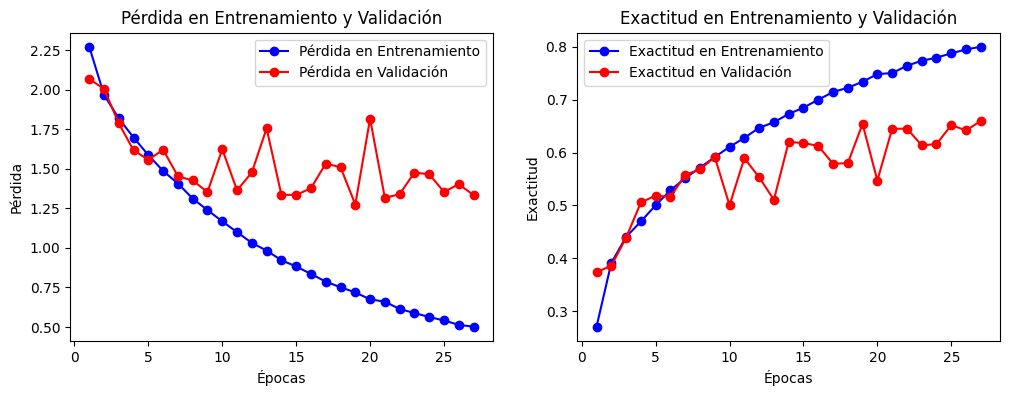

In [44]:
import matplotlib.pyplot as plt

# Supongamos que `history` es el resultado del entrenamiento del modelo
history_dict = history.history

# Extraer métricas de historial
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Pérdida en Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida en Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la exactitud
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Exactitud en Entrenamiento')
plt.plot(epochs, val_accuracy, 'ro-', label='Exactitud en Validación')
plt.title('Exactitud en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

plt.show()
